# Single and multiple imputations with MIWAE


In this notebook, we'll show how to learn a deep generative model on a small and **incomplete** continuous data set. We will also show how to **perform multiple imputations** of the missing values of this data set. 

This is based on the following paper, available [on arXiv](https://arxiv.org/abs/1812.02633):

P.-A. Mattei & J. Frellsen, **MIWAE: Deep Generative Modelling and Imputation of Incomplete Data Sets**, *Proceedings of the 36th International Conference on Machine Learning*, PMLR 97:4413-4423, 2019.

It is possible to run this notebook in Google Colab, which allows to benefit from free GPU computing.
<table class="tfo-notebook-buttons" align="left">
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/pamattei/MIWAE_demo_UCI.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>


# Installing and loading useful stuff

In [1]:
import tensorflow as tf
import numpy as np
import scipy.stats
import scipy.io
import scipy.sparse
from scipy.io import loadmat
import pandas as pd
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tf.keras
tfkl = tf.keras.layers
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn import preprocessing
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [2]:
def mse(xhat,xtrue,mask): # MSE function for imputations
    mask = mask.astype(np.bool)   
    xhat = np.array(xhat)
    xtrue = np.array(xtrue)
    return np.mean(np.power(xhat-xtrue,2)[~mask])

# Loading the data

We'll use the Breast cancer data set from scikit-learn:



In [3]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(True)[0].astype(np.float32)

It is also possible to another tabular data set by uncommenting one of the following cells:

In [4]:
#from sklearn.datasets import load_iris
#iris = load_iris()
#data = iris.data.astype(np.float32)
#target = iris.target

In [5]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
#data = np.array(pd.read_csv(url, low_memory=False, sep=';')).astype(np.float32)

In [6]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
#data = np.array(pd.read_csv(url, low_memory=False, sep=';')).astype(np.float32)

In [7]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
#data = np.array(pd.read_csv(url, low_memory=False, sep=','))[:,0:4].astype(np.float32)
#target = np.array(pd.read_csv(url, low_memory=False, sep=','))[:,4]

We now standardise the data:

In [8]:
xfull = (data - np.mean(data,0))/np.std(data,0)
n = xfull.shape[0] # number of observations
p = xfull.shape[1] # number of features

We will remove uniformy at random 50% of the first features. This 
corresponds to a *missing completely at random (MCAR)* scenario. The MIWAE also works in more challenging *missing at random (MAR)* situations. For more info on what MCAR, MAR, and MNAR mean, you can look for example at [these nice lecture notes](http://juliejosse.com/wp-content/uploads/2018/07/LectureNotesMissing.html) by Julie Josse, Wei Jiang, Aude Sportisse, and Geneviève Robin. We also recently published and [extension of MIWAE to handle MNAR data](https://openreview.net/forum?id=tu29GQT0JFy) at ICLR 2021.

In [9]:
np.random.seed(1234)

perc_miss = 0.5 # 50% of missing data
xmiss = np.copy(xfull)
xmiss_flat = xmiss.flatten()
miss_pattern = np.random.choice(n*p, np.floor(n*p*perc_miss).astype(np.int), replace=False)
xmiss_flat[miss_pattern] = np.nan 
xmiss = xmiss_flat.reshape([n,p]) # in xmiss, the missing values are represented by nans
mask = np.isfinite(xmiss).astype(np.float32) # binary mask that indicates which values are missing

A simple way of imputing the incomplete data is to replace the missing values by zeros. This x_hat0 is what will be fed to our encoder.

In [10]:
xhat_0 = np.copy(xmiss)
xhat_0[np.isnan(xmiss)] = 0

## The model

We will use a **deep latent variable model with a Gaussian prior and a Student's t observation model**. This can be written:

$$p(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p(\mathbf{x}_i|\mathbf{z}_i) = \text{St} (\mathbf{x}_i|\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}_i),\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}_i),\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\mu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}^p$, $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathcal{S}_p^{++}$, and $\boldsymbol{\nu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}_+^p$ are functions parametrised by deep neural nets.

The weights of these nets are stored in a parameter $\boldsymbol{\theta}$. We choose to use the following simple architecture, where the 3 neural nets share the first layers:

$$f_{\boldsymbol{\theta}} (\mathbf{z})=\sigma(\mathbf{W}_1\sigma(\mathbf{W}_0\mathbf{z}+\mathbf{b}_0)+\mathbf{b}_1) $$

$$\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}) = \mathbf{W}_\boldsymbol{\mu}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\mu}, $$

$$\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}) = \text{Diag}\left(\text{Softplus}(\mathbf{W}_\boldsymbol{\sigma}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\sigma}) + 10^{-3}\right), $$

$$\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z}) = \text{Softplus}(\mathbf{W}_\boldsymbol{\nu}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\nu}) + 3. $$

A few **non-essential remarks** about this architecture:

* This parametrisation is quite close to the one we use in the MIWAE paper. The main difference is that we use $\sigma = \text{ReLU}$ (which leads to faster training) while we used $\sigma = \text{tanh}$ in the paper.
*   We use a [location-scale parametrisation](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family) of the t distribution, following [the parametrisation available in TensorFlow](https://www.tensorflow.org/api_docs/python/tf/distributions/StudentT). Note in particular that $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$ is not the covariance matrix of $\mathbf{x} | \mathbf{z}$. When it exitsts, the actual covariance matrix is diagonal with diagonal  $$ \frac{\text{diag}(\boldsymbol{\Sigma}_{\boldsymbol{\theta}} (\mathbf{z}))^2 \boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z})}{\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z})-2}$$ (where all operations are made entrywise).
*   The fact that the covariance matrix is diagonal means that we assume that **the features are independent conditionnally on the latent variable** (which is customary for DLVMs).
* We add $3$ to the neural net that outputs the degrees of freedom. This is to guarantee that the tails of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ are not too heavy. Indeed, having too heavy tails might imply that the mean of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ does not exist! Adding 3 implies that the degrees of freedom is always larger than 3, implying in turn that **at least the first 3 moments of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ are well-defined.**
* We add $10^{-3}$ to the diagonal entries of $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}$ to prevent singularities, [as advocated in our NeurIPS 2018 paper](https://papers.nips.cc/paper/7642-leveraging-the-exact-likelihood-of-deep-latent-variable-models). Why $10^{-3}$ specifically? Because, since the data have unit variance, this will imply that the latent variable explains at most $99.9999\%$ of the variance of the data, which does not seem too restrictive. **This choice might be poor if the data are not standardised.**




Like in the MIWAE paper, we choose to assume that the dimension of the latent space is $d = 10$. The breast cancer data set has $d = 30$ features. Roughly speaking, we assume that these $30$-dimensional points lie close to a $10$-dimensional manifold. In practice, the manifold learned after training is likely to actually be of dimension less than $10$ (a property called *emergent sparsity* by [Dai et al., JMLR 2018](https://jmlr.org/papers/v19/17-704.html)).

In [11]:
d = 10 # 10D manifold
p_z = tfd.MultivariateNormalDiag(loc=tf.zeros(d, tf.float32))

In [12]:
h = 128 # number of hidden units (same for all MLPs)

sigma = "relu"

decoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[d,]),
  tfkl.Dense(h, activation=sigma,kernel_initializer="he_normal"),
  tfkl.Dense(h, activation=sigma,kernel_initializer="he_normal"),
  tfkl.Dense(3*p,kernel_initializer="he_normal") # the decoder will output both the mean, the scale, and the number of degrees of freedoms (hence the 3*p)
])

## Building the inference network (*aka* encoder)

We will build a Student's t posterior approximation by using an **encoder** that mimicks the architecture of the decoder.


The imputation function $\iota$ replaces the missing values by learned constants. Note that this is slightly more general than what we use in the paper (which was just replacing missing values by zeros). We just initialise it using zeros.

In [13]:
iota = tf.Variable(np.zeros([1,p]),dtype=tf.float32) # this will be updated during training

In [14]:
encoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[p,]),
  tfkl.Dense(h, activation=sigma,kernel_initializer="he_normal"),
  tfkl.Dense(h, activation=sigma,kernel_initializer="he_normal"),
  tfkl.Dense(h, activation=sigma,kernel_initializer="he_normal"),
  tfkl.Dense(3*d,kernel_initializer="he_normal")
])

# Computing the MIWAE bound

We now have everything we need to compute our lower-bound on the log-likelihood of the observed data. The MIWAE bound is defined as
$$
\mathcal{L}_K (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z}_{i1},\ldots,\mathbf{z}_{iK} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}^\text{o}_i)} \left[ \log\frac{1}{K} \sum_{k=1}^K \frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i^\text{o}|\mathbf{z}_{ik})p(\mathbf{z}_{ik})}{q_{\boldsymbol{\gamma}}(\mathbf{z}_{ik}|\mathbf{x}^\text{o}_i)} \right].
$$

In [15]:
@tf.function
def miwae_bound(xhat_0_batch, mask_batch,K):

    tiledmask = tf.tile(mask_batch,[K,1])
    mask_complement_float = tf.abs(mask_batch-1)

    tilediota = tf.tile(iota,[xhat_0_batch.shape[0],1])
    iotax = xhat_0_batch + tf.multiply(tilediota,mask_complement_float)

    out_encoder = encoder(iotax)
    q_zgivenxobs = tfd.Independent(distribution=tfd.StudentT(loc=out_encoder[..., :d], scale=tf.nn.softplus(out_encoder[..., d:(2*d)]), df=3 + tf.nn.softplus(out_encoder[..., (2*d):(3*d)])))
    zgivenx = q_zgivenxobs.sample(K)
    zgivenx_flat = tf.reshape(zgivenx,[K*xhat_0_batch.shape[0],d])

    out_decoder = decoder(zgivenx_flat)
    data_flat = tf.reshape(tf.tile(xhat_0_batch,[K,1]),[-1,1])
    all_means_obs_model = out_decoder[..., :p]
    all_scales_obs_model = tf.nn.softplus(out_decoder[..., p:(2*p)]) + 0.001
    all_degfreedom_obs_model = tf.nn.softplus(out_decoder[..., (2*p):(3*p)]) + 3
    all_log_pxgivenz_flat = tfd.StudentT(loc=tf.reshape(all_means_obs_model,[-1,1]),scale=tf.reshape(all_scales_obs_model,[-1,1]),df=tf.reshape(all_degfreedom_obs_model,[-1,1])).log_prob(data_flat)
    all_log_pxgivenz = tf.reshape(all_log_pxgivenz_flat,[K*xhat_0_batch.shape[0],p])

    logpxobsgivenz = tf.reshape(tf.reduce_sum(tf.multiply(all_log_pxgivenz,tiledmask),1),[K,xhat_0_batch.shape[0]])
    logpz = p_z.log_prob(zgivenx)
    logq = q_zgivenxobs.log_prob(zgivenx)

    average_miwae_bound = tf.reduce_mean(tf.reduce_logsumexp(logpxobsgivenz + logpz - logq,0) -tf.math.log(tf.cast(K,tf.float32)) ) 
    return average_miwae_bound

# Single and multiple imputation

The optimal (in the $\ell_2$ sense, and according to our model $p_{\boldsymbol{\theta}}$) single imputation is the conditional mean $\mathbb{E}_{p_{\boldsymbol{\theta}}} [\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}}]$. This can be estimated using self-normalised importance sampling:
\begin{equation}
\mathbb E _{p_{\boldsymbol{\theta}}}[\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}}] \approx \sum_{l=1}^L w_l \mathbb{E}_{p_{\boldsymbol{\theta}}}\left[\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}},\mathbf{z}_{(l)}\right] = \sum_{l=1}^L w_l \boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}_l)^\text{m},
\end{equation}


\begin{equation}
w_l=\frac{r_l}{r_1+...+r_L}, \; \text{with} \; r_l = \frac{p_{\boldsymbol{\theta}}(\mathbf{x}^{\text{o}}|\mathbf{z}_{(l)})p(\mathbf{z}_{(l)})}{q_{\boldsymbol{\gamma}}(\mathbf{z}_{(l)}|\mathbf{x}^{\text{o}})}.
\end{equation}

For more details on this, see section 3.2 of the [MIWAE paper](http://proceedings.mlr.press/v97/mattei19a.html). Usually, the number $L$ of importance samples used for imputation is chosen to be much larger than the number of importance samples $K$ used for training. Typically $K=50$ and $L=10000$ is a decent choice in low-dimensional settings.

One issue with single imputation is that it is just a point estimate of $\mathbf{x}^{\text{m}}$, that does not tell us anything about the uncertainties of our imputations. A way to assess these uncertainties is through **multiple imputation**. In our context, a natural route to multiple imputation is to sample several i.i.d. imputations from the conditional distribution $p_{\boldsymbol{\theta}}(\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}})$. Sampling from this distribution is not straightforward, but can approximatively be done using the same importance weights used for single imputation, by relying on **sampling importance resampling**.

The simple process to sample $M$ samples from the condtional distribution goes at follows. First, for some $L\gg M$, we sample $(\mathbf{x}^{\text{m}}_{(1)},\mathbf{z}_{(1)}),\ldots,(\mathbf{x}^{\text{m}}_{(L)},\mathbf{z}_{(L)})$ and compute the weights similarly to single imputation. Then, we sample $M$ imputations with replacement from the set $\{\mathbf{x}^{\text{m}}_{(1)},\ldots,\mathbf{x}^{\text{m}}_{(L)} \}$, the probability of each sample being exactly its importance weight.

This means that both single and multiple imputation can be done by reusing the same computations, as in the following function. When $L \longrightarrow \infty$, the single imputation will converge to $\mathbb{E}_{p_{\boldsymbol{\theta}}} [\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}}]$, and the multiple imputations will be i.i.d. samples from the conditional distribution $p_{\boldsymbol{\theta}}(\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}})$.

In [16]:
@tf.function
def miwae_impute(xhat_0_batch, mask_batch,L=1000,kind="single",num_samples=20):

    # kind = "single" will return only the single imputation
    # kind = "multiple" will return num_samples multiple imputations
    # kind = "both" will both the single imputation and num_samples multiple imputations

    tiledmask = tf.tile(mask_batch,[L,1])
    mask_complement_float = tf.abs(mask_batch-1)

    tilediota = tf.tile(iota,[xhat_0_batch.shape[0],1])
    iotax = xhat_0_batch + tf.multiply(tilediota,mask_complement_float)

    out_encoder = encoder(iotax)
    q_zgivenxobs = tfd.Independent(distribution=tfd.StudentT(loc=out_encoder[..., :d], scale=tf.nn.softplus(out_encoder[..., d:(2*d)]), df=3 + tf.nn.softplus(out_encoder[..., (2*d):(3*d)])))
    zgivenx = q_zgivenxobs.sample(L)
    zgivenx_flat = tf.reshape(zgivenx,[L*xhat_0_batch.shape[0],d])

    out_decoder = decoder(zgivenx_flat)
    data_flat = tf.reshape(tf.tile(xhat_0_batch,[L,1]),[-1,1])
    all_means_obs_model = out_decoder[..., :p]
    all_scales_obs_model = tf.nn.softplus(out_decoder[..., p:(2*p)]) + 0.001
    all_degfreedom_obs_model = tf.nn.softplus(out_decoder[..., (2*p):(3*p)]) + 3
    xgivenz = tfd.Independent(distribution=tfd.StudentT(loc=all_means_obs_model, scale=all_scales_obs_model, df=all_degfreedom_obs_model))
    all_log_pxgivenz_flat = tfd.StudentT(loc=tf.reshape(all_means_obs_model,[-1,1]),scale=tf.reshape(all_scales_obs_model,[-1,1]),df=tf.reshape(all_degfreedom_obs_model,[-1,1])).log_prob(data_flat)
    all_log_pxgivenz = tf.reshape(all_log_pxgivenz_flat,[L*xhat_0_batch.shape[0],p])

    logpxobsgivenz = tf.reshape(tf.reduce_sum(tf.multiply(all_log_pxgivenz,tiledmask),1),[L,xhat_0_batch.shape[0]])
    logpz = p_z.log_prob(zgivenx)
    logq = q_zgivenxobs.log_prob(zgivenx)

    log_imp_weights = logpxobsgivenz + logpz - logq # same importance wieghts used for single and multiple imputation

    if ((kind=="single") or (kind=="both")):

        imp_weights = tf.nn.softmax(log_imp_weights,0) # these are w_1,....,w_L for all observations in the batch
        xms = tf.reshape(xgivenz.mean(),[L,xhat_0_batch.shape[0],p])
        xm = xhat_0_batch + tf.multiply(tf.einsum('ki,kij->ij', imp_weights, xms),mask_complement_float)

    if ((kind=="multiple") or (kind=="both")):

        sir_logits = tf.transpose(log_imp_weights)
        sir = tfd.Categorical(logits = sir_logits).sample(num_samples)
        xmul = tf.reshape(xhat_0_batch + tf.multiply(tf.reshape(xgivenz.sample(),[L,xhat_0_batch.shape[0],p]),mask_complement_float),[L,xhat_0_batch.shape[0],p])

    if (kind=="single"):
        return xm

    if (kind=="multiple"):
        return tf.gather(tf.transpose(xmul,perm=[1,0,2]), tf.transpose(sir), axis = 1, batch_dims=1)

    if (kind=="both"):
        return xm, tf.gather(tf.transpose(xmul,perm=[1,0,2]), tf.transpose(sir), axis = 1, batch_dims=1)

# Training the model

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

In [18]:
all_parameters = encoder.trainable_variables + decoder.trainable_variables + [iota]

In [19]:
@tf.function
def gradient_step_miwae(xhat_0_batch, mask_batch,K):
      with tf.GradientTape() as tape: # the gradient tape saves all the step that needs to be saved fopr automatic differentiation
        loss = -  miwae_bound(xhat_0_batch, mask_batch,K)  # the loss is the negative ELBO
      gradients = tape.gradient(loss, all_parameters)  # here, the gradient is automatically computed
      optimizer.apply_gradients(zip(gradients, all_parameters))  # Adam iteration

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((xhat_0,mask)).shuffle(n).batch(32) # TF creates the batches for us

In [21]:
EPOCHS = 1001
mse_miwae=np.array([])
xhat_miwae = np.copy(xhat_0)

for epoch in range(1,EPOCHS+1):
  for xhat_0_batch, mask_batch in train_dataset:
    gradient_step_miwae(xhat_0_batch, mask_batch,K = 20) # Adam iteration
  
  if (epoch % 500) == 1:
    for i in range(n):
      xhat_miwae[i,:]  = miwae_impute(xhat_0[i,:].reshape([1,p]), mask[i,:].reshape([1,p]), kind = "single",L = 10000).numpy()
    err = np.array([mse(xhat_miwae,xfull,mask)])
    train_miwae_bound = miwae_bound(xhat_0, mask, K = 20)
    mse_miwae = np.append(mse_miwae,err,axis=0)
    print('Epoch  %g' %epoch)
    print('Train MIWAE bound  %g' %train_miwae_bound.numpy())
    print('Imputation MSE  %g' %err)
    print('-----------')

Epoch  1
Train MIWAE bound  -36.7326
Imputation MSE  1.73124
-----------
Epoch  501
Train MIWAE bound  -6.91025
Imputation MSE  0.286985
-----------
Epoch  1001
Train MIWAE bound  -3.61088
Imputation MSE  0.286728
-----------


# How good are single imputations?

Now that we have trained our model, we can compare our single imputations with other methods, notably [scikit-learn's iterative imputer](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py), which, used together with the $\texttt{ExtraTreesRegressor}$ option, is akin the the strong [missforest](https://academic.oup.com/bioinformatics/article/28/1/112/219101) baseline. We also look at the classical mean impputation technique.

In [22]:
missforest = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=100, max_depth = 8)) # max_depth = 8 helps with the memory footprint
missforest.fit(xmiss)
xhat_mf = missforest.transform(xmiss)
mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
mean_imp.fit(xmiss)
xhat_mean = mean_imp.transform(xmiss)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


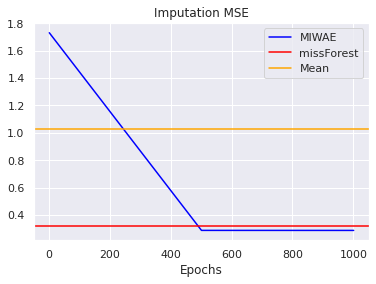

In [23]:
plt.plot(np.linspace(1,EPOCHS,mse_miwae.shape[0]),mse_miwae,color="blue")
plt.axhline(y=mse(xhat_mf,xfull,mask),  linestyle='-',color="red")
plt.axhline(y=mse(xhat_mean,xfull,mask),  linestyle='-',color="orange")
plt.legend(["MIWAE","missForest","Mean"])
plt.title("Imputation MSE")
plt.xlabel("Epochs")
plt.show()

# Multiple imputation

We will visually inspect the multiple imputations of several points. To this end, we choose some data points where at least two features are missing, and visualise:

*   The ground truth of the observed data
*   The single imputations given by MIWAE and missForest
*   A bunch (here, 20) of mutliple imputations given by MIWAE

In [24]:
i = 100 # index of the data point (it needs to have at least two missing values)
num_samples = 20 # number of multiple imputations

if (np.sum(mask[i,:])>p-2):
  print('This data point has less than two missing values, therefore the visualisation will fail.')

xhat_single, xhat_multiple  = miwae_impute(xhat_0[i,:].reshape([1,p]), mask[i,:].reshape([1,p]), kind = "both",L = 10000, num_samples = num_samples)

true_values = xfull[i,~mask[i,:].astype(bool)]
single_imp = np.squeeze(xhat_single.numpy()[:,~mask[i,:].astype(bool)])
mul_imp = np.squeeze(xhat_multiple.numpy()[:,:,~mask[i,:].astype(bool)])
missfo = xhat_mf[i,~mask[i,:].astype(bool)]

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


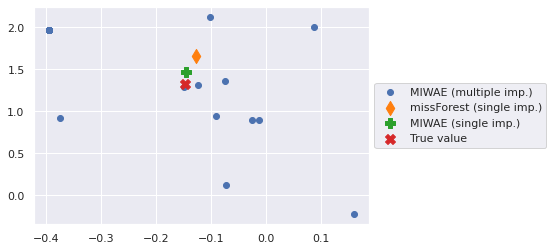

In [25]:
plt.scatter(x=mul_imp[:,0],y=mul_imp[:,1])
plt.scatter(x=missfo[0],y=missfo[1], s =100, marker = "d", c = '#ff7f0e')
plt.scatter(x=single_imp[0],y=single_imp[1], s =100, marker = "P",  c = '#2ca02c')
plt.scatter(x=true_values[0],y=true_values[1], s =100, marker = "X",  c = '#d62728')
plt.legend(["MIWAE (multiple imp.)","missForest (single imp.)","MIWAE (single imp.)", "True value"],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We can see that the model accurately assess its uncertainty! Another interesting thing to do is to plot a kernel density estimate (KDE) of many multiple imputations. For the same point as before, we sample 500 multiple imputations, and compare the KDE with the ground truth and the single imputations.

In [26]:
xhat_single, xhat_multiple  = miwae_impute(xhat_0[i,:].reshape([1,p]), mask[i,:].reshape([1,p]), kind = "both",L = 50000, num_samples = 500)

true_values = xfull[i,~mask[i,:].astype(bool)]
single_imp = np.squeeze(xhat_single.numpy()[:,~mask[i,:].astype(bool)])
mul_imp = np.squeeze(xhat_multiple.numpy()[:,:,~mask[i,:].astype(bool)])
missfo = xhat_mf[i,~mask[i,:].astype(bool)]

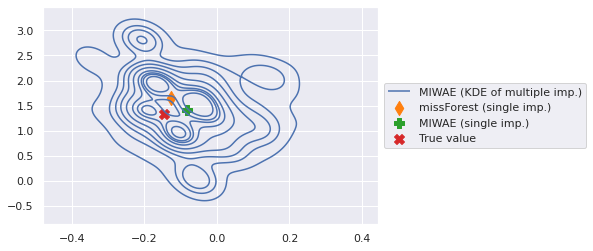

In [27]:
sns.kdeplot(x=mul_imp[:,0],y=mul_imp[:,1])
plt.scatter(x=missfo[0],y=missfo[1], s =100, marker = "d", c = '#ff7f0e')
plt.scatter(x=single_imp[0],y=single_imp[1], s =100, marker = "P",  c = '#2ca02c')
plt.scatter(x=true_values[0],y=true_values[1], s =100, marker = "X",  c = '#d62728')
plt.legend(["MIWAE (KDE of multiple imp.)","missForest (single imp.)", "MIWAE (single imp.)","True value"],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Again, it seems that the model thinks that the ground truth value is quite likely.

Another interesting thing to look at is to compare $p_{\boldsymbol{\theta}}(\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}})$ and $p(\mathbf{x}^{\text{m}})$. As one would expect, $p_{\boldsymbol{\theta}}(\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}})$ has much lower variance (and entropy) than $p(\mathbf{x}^{\text{m}})$: this illustrates that $\mathbf{x}^{\text{o}}$ provides some information about the value of $\mathbf{x}^{\text{m}}$. 

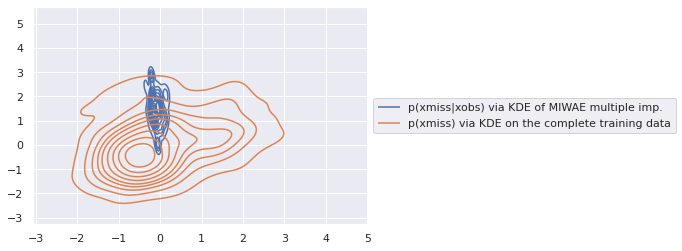

In [28]:
sns.kdeplot(x=mul_imp[:,0],y=mul_imp[:,1])
sns.kdeplot(x=xfull[:,~mask[i,:].astype(bool)][:,0],y=xfull[:,~mask[i,:].astype(bool)][:,1])
plt.legend(["p(xmiss|xobs) via KDE of MIWAE multiple imp.","p(xmiss) via KDE on the complete training data"],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Let's finally look at another point:

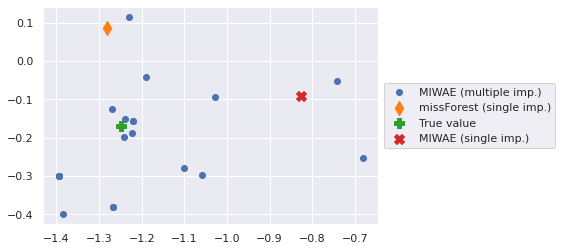

In [29]:
i = 10 # index of the data point (it needs to have at least two missing values)
num_samples = 20 # number of multiple imputations

if (np.sum(mask[i,:])>p-2):
  print('This data point has less than two missing values, therefore the visualisation will fail.')

xhat_single, xhat_multiple  = miwae_impute(xhat_0[i,:].reshape([1,p]), mask[i,:].reshape([1,p]), kind = "both",L = 10000, num_samples = num_samples)

true_values = xfull[i,~mask[i,:].astype(bool)]
single_imp = np.squeeze(xhat_single.numpy()[:,~mask[i,:].astype(bool)])
mul_imp = np.squeeze(xhat_multiple.numpy()[:,:,~mask[i,:].astype(bool)])
missfo = xhat_mf[i,~mask[i,:].astype(bool)]

plt.scatter(x=mul_imp[:,0],y=mul_imp[:,1])
plt.scatter(x=missfo[0],y=missfo[1], s =100, marker = "d", c = '#ff7f0e')
plt.scatter(x=single_imp[0],y=single_imp[1], s =100, marker = "P",  c = '#2ca02c')
plt.scatter(x=true_values[0],y=true_values[1], s =100, marker = "X",  c = '#d62728')
plt.legend(["MIWAE (multiple imp.)","missForest (single imp.)", "True value","MIWAE (single imp.)"],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [30]:
xhat_single, xhat_multiple  = miwae_impute(xhat_0[i,:].reshape([1,p]), mask[i,:].reshape([1,p]), kind = "both",L = 50000, num_samples = 500)

true_values = xfull[i,~mask[i,:].astype(bool)]
single_imp = np.squeeze(xhat_single.numpy()[:,~mask[i,:].astype(bool)])
mul_imp = np.squeeze(xhat_multiple.numpy()[:,:,~mask[i,:].astype(bool)])
missfo = xhat_mf[i,~mask[i,:].astype(bool)]

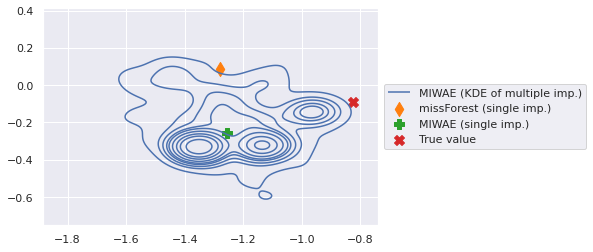

In [31]:
sns.kdeplot(x=mul_imp[:,0],y=mul_imp[:,1])
plt.scatter(x=missfo[0],y=missfo[1], s =100, marker = "d", c = '#ff7f0e')
plt.scatter(x=single_imp[0],y=single_imp[1], s =100, marker = "P",  c = '#2ca02c')
plt.scatter(x=true_values[0],y=true_values[1], s =100, marker = "X",  c = '#d62728')
plt.legend(["MIWAE (KDE of multiple imp.)","missForest (single imp.)", "MIWAE (single imp.)","True value"],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()